# Classification Main-Pied - REGION INTERET

## Apprentissage sur stimulation; Test sur imagination

Classification sur voxels 
Masque système moteur obtenus à partir de cartes ICA de NeuroVault (meta analyses) en selectionant mots clés: motor, premotor, sma, foot, hand 
exemple: http://nilearn.github.io/auto_examples/05_advanced/plot_ica_neurovault.html#sphx-glr-auto-examples-05-advanced-plot-ica-neurovault-py

Tous les sujets - Classifieur: GraphNet

### Visualisation des masques

In [4]:
from nilearn.plotting import plot_roi
%matplotlib inline

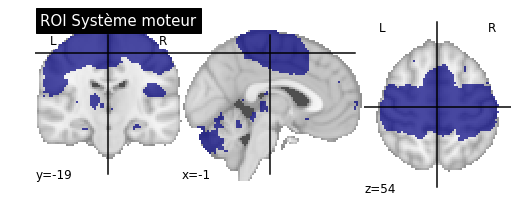

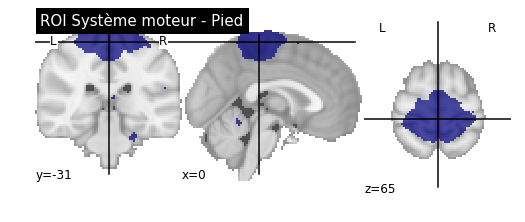

In [6]:
mask='F:/IRM_Marche/ICAMask.nii.gz'
footmask='F:/IRM_Marche/ICAFootMask.nii.gz'

plot_roi(mask, title='ROI Système moteur')
plot_roi(footmask, title='ROI Système moteur - Pied')

In [7]:
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
import pandas as pd
from sklearn import preprocessing 
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.externals.joblib import Memory
from sklearn.linear_model import LogisticRegression
from nilearn.datasets import load_mni152_brain_mask,load_mni152_template
from nilearn.image import resample_img
from nilearn import plotting, image 
from nibabel.nifti1 import Nifti1Image
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import os.path  
import sys 
sys.path[0]='Z:\GitHub\gsp-learn'
from gsplearn.GSPPlot import plot_selectedregions
from sklearn.externals.joblib import Memory


C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
mem = Memory('nilearn_cache')
mask='F:/IRM_Marche/ICAFootMask.nii.gz'
#mask='F:/IRM_Marche/ICAMask.nii.gz'
names={'ap':'ALLAIN',
       'as':'ANDRE',
       'bh':'BEAUGE',
       'bi':'BROCHARD',
       'cmp':'CAPERAN',
       'cas':'CASINTHIE',
       'cs':'CHOIMET',
       'cb':'CHOLOUX',
       'gm':'GAUTIER',
       'gn':'GAUTIERNATH',
       'gbn':'GOURDONBELLARD',
       'mv':'MAROT',
       'ms':'MICHEL',
       'pm':'PAILLEY',
       'pc':'PAPON',
       'ph':'PESNEL',
       'pa':'PETIT',
       'pv':'PIC',
       'pom':'PONTIE',
       'rdc':'RODRIGUEZDIAZ',
       'ti':'TESSON',
       'vs':'VANWATERLOO',
       }
smt='ss'
fold_g = 'F:/IRM_Marche/'
blocks=np.loadtxt(fold_g+'block_main.txt','int')
label=np.loadtxt(fold_g+'label_main.txt','S12')
mask_block=blocks==blocks
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        mask_block[x]=False
    elif label[x,0]!=label[x-2,0]:
        mask_block[x]=False
        
sessions=np.concatenate((np.zeros(150),np.ones(150),2*np.ones(150),3*np.ones(150),4*np.ones(150)) ) 

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= np.logical_and(condition_cat,condition_out)
condition_mask2= np.logical_and(condition_mask,mask_block)

stim_mask=np.logical_and(condition_mask2,(label[:,0]==b'stim'))
imag_mask=np.logical_and(condition_mask2,(label[:,0]==b'imag'))

block=blocks[stim_mask]
y_train=label[stim_mask,1]
y_test=label[imag_mask,1]

In [9]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(
        mask_img=mask, memory_level=1,
        detrend=True,t_r=2.28,high_pass=0.01,sessions=sessions,
        memory=mem)
masker = masker.fit()
    
from nilearn.decoding import SpaceNetClassifier
decoder = SpaceNetClassifier(alphas=1,memory="nilearn_cache", penalty='graph-net',verbose=0)
from nilearn.plotting import plot_stat_map, show

________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x000000000F3AD6A0>, target_affine=None, copy=False, target_shape=None)
_____________________________________________________resample_img - 0.0s, 0.0min


## Train on all subjects

In [ ]:
# Get DATA
y_train_all=np.zeros([0,1])
y_test_all=np.zeros([0,1])
block_all=np.zeros([0,1])
from nilearn.image import concat_imgs
for i,(n,foldn) in enumerate(names.items()):
    sim_filename=os.path.join(fold_g,'Temoins_40_60ans',foldn,'Suj','Functional','all_'+smt+'_'+n+'.nii.gz')  
    confounds=os.path.join(fold_g,'Temoins_40_60ans',foldn,'Suj','Functional',n+'_confounds_cond.csv')
    if os.path.exists(sim_filename):
        data=masker.transform(sim_filename, confounds=confounds)
        data_train=data[stim_mask]
        data_test=data[imag_mask]
        y_train_all=np.append(y_train_all,y_train)
        y_test_all=np.append(y_test_all,y_test)
        block_all=np.append(block_all,block)
        img_train=masker.inverse_transform(data_train)
        img_test=masker.inverse_transform(data_test)
        if i>0:
            X_train=concat_imgs((X_train,img_train))
            X_test=concat_imgs((X_test,img_test))
        else:
            X_train=img_train
            X_test=img_test

In [ ]:
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.     
coef_img = decoder.coef_img_
coef_img.to_filename(os.path.join('D:/marche_result','all_graph-net_weights_trainimag.nii'))
plot_stat_map(coef_img, title=n+"graph-net: accuracy %g%%" % accuracy,cmap='bwr')

## Individuel (résultats)

	Train IMAG	Train Stim
ti	61.40350877	53.50877193

pom	54.38596491	53.50877193

mv	69.29824561	43.85964912

pm	42.10526316	50.87719298

pc	37.71929825	56.14035088

vs	59.64912281	52.63157895

ms	83.33333333	71.05263158

ph	73.68421053	64.9122807

cb	74.56140351	62.28070175

cmp	82.45614035	74.56140351

pa	70.1754386	62.28070175

bh	67.54385965	59.64912281

pv	72.80701754	56.14035088

bi	42.98245614	57.01754386

gbn	57.89473684	48.24561404

gn	56.14035088	42.10526316

ap	62.28070175	48.24561404

gm	57.01754386	57.89473684

cas	50	        51.75438596

rdc	57.89473684	54.38596491

cs	83.33333333	78.94736842

as	55.26315789	47.36842105

		
Total	62.36044657	56.69856459
